<a href="https://colab.research.google.com/github/itsamepetros/BigData2021/blob/main/Lab6/Lab6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch.nn as nn
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import seaborn as sns
from torchsummary import summary
from tqdm import tqdm as tqdm

In [3]:
url = 'https://raw.githubusercontent.com/rslab-ntua/MSc_GBDA/master/2020/Exercise_ML2/test_split.json'
test = pd.read_json(url)
test = test[0].str.split('/', 3, expand=True)
test = test.rename(columns={0:'index', 1:'label', 2:'img'})

url = 'https://raw.githubusercontent.com/rslab-ntua/MSc_GBDA/master/2020/Exercise_ML2/train_split.json'
train = pd.read_json(url)
train = train[0].str.split('/', 3, expand=True)
train = train.rename(columns={0:'index',1:'label', 2:'img'})

url = 'https://raw.githubusercontent.com/rslab-ntua/MSc_GBDA/master/2020/Exercise_ML2/val_split.json'
valid = pd.read_json(url)
valid = valid[0].str.split('/', 3, expand=True)
valid = valid.rename(columns={0:'index', 1:'label', 2:'img'})

print(len(train), len(valid), len(test))

18900 4050 4050


In [ ]:
train.head(20)

,index,label,img
0,2750,River,River_2132.jpg
1,2750,HerbaceousVegetation,HerbaceousVegetation_868.jpg
2,2750,Highway,Highway_316.jpg
3,2750,Residential,Residential_2628.jpg
4,2750,Industrial,Industrial_1304.jpg
5,2750,AnnualCrop,AnnualCrop_1615.jpg
6,2750,SeaLake,SeaLake_1227.jpg
7,2750,SeaLake,SeaLake_677.jpg
8,2750,Forest,Forest_2496.jpg
9,2750,Forest,Forest_2532.jpg


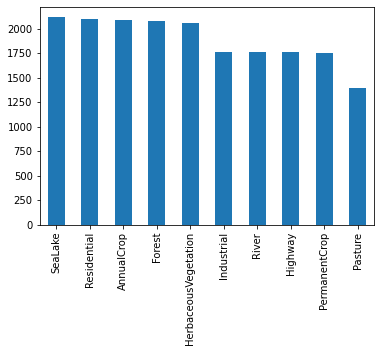

In [ ]:
train['label'].value_counts().plot(kind='bar')

In [4]:
idx_class_labels = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
class_idx_labels = dict()


for key, val in idx_class_labels.items():
  class_idx_labels[val] = key

class_idx_labels

num_class = len(class_idx_labels.items())


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
root_path = '/content/drive/MyDrive'
data_path = os.path.join(root_path, '2750')

In [7]:
def encode_label(label):
    idx = class_idx_labels[label]
    return idx

def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return idx_class_labels[target]
    else:
        return target

In [8]:
class Eurosat(Dataset):
    def __init__(self, train, dir, transform=None):
        self.train = train
        self.dir = dir
        self.transform = transform

    def __len__(self):
        return len(self.train)

    def __getitem__(self,idx):
        row = self.train.loc[idx]
        img_id, label = row['img'], row['label']

        img = Image.open(os.path.join(self.dir, img_id.split('.')[0].split('_')[0], img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

In [9]:
img_transform = {

    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
         #                    [0.229, 0.224, 0.225])  # Imagenet standards
    ]),

    'valid':
    transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
         #                    [0.229, 0.224, 0.225])
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406],
         #                    [0.229, 0.224, 0.225])
    ]),
}


In [10]:
train_Dataset = Eurosat(train, data_path, img_transform['train'])
valid_Dataset = Eurosat(valid, data_path, img_transform['valid'])
train_dl = DataLoader(train_Dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_Dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

test_Dataset = Eurosat(test, data_path, img_transform['test'])
test_dl = DataLoader(test_Dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

print(len(train_Dataset))
print(len(valid_Dataset))
print(len(train_dl))
print(len(valid_dl))

18900
4050
591
127


In [ ]:
trainiter = iter(train_dl)
images, labels = next(trainiter)
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

tensor([6, 4, 6, 3, 3, 1, 5, 6, 9, 1, 9, 1, 9, 7, 8, 6, 2, 0, 1, 4, 3, 4, 7, 4,
        1, 1, 2, 9, 4, 2, 9, 8])
tensor([3, 0, 8, 8, 4, 9, 4, 1, 0, 7, 9, 4, 0, 2, 6, 8, 3, 0, 1, 2, 1, 5, 6, 5,
        9, 5, 1, 2, 7, 6, 8, 5])


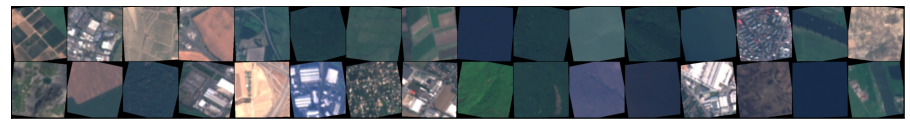

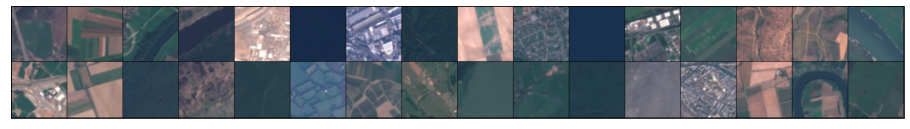

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        print(labels)
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        
        break

show_batch(train_dl)
show_batch(valid_dl)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")
print(device)

cuda:0


In [ ]:
from torchvision import models
model = models.resnet18(pretrained=True)
print(model)
summary(model, (3, 224, 224), device='cpu')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
#model.classifier
model.fc = nn.Linear(512, num_class)
model.fc

Linear(in_features=512, out_features=10, bias=True)

In [ ]:
#class TLNet(nn.Module):
#    def __init__(self, model):
#        super().__init__()
#        self.conv_features = model.features
#        
#        self.classifier =  nn.Sequential(
#                        nn.Flatten(),
#                        nn.Linear(32768, 256),
#                        nn.ReLU(),
#                        nn.Dropout(0.4),
#                        nn.Linear(256, num_class),
#                        nn.LogSoftmax(dim=1)
#)
#
#
#    def forward(self, x):
#        x = self.conv_features(x)
#        x = self.classifier(x)
#        return x

#tl_net = TLNet(model)

In [ ]:
summary(model,(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
#model.classifier[6] =  nn.Sequential(
#                        nn.Linear(4096, 256),
#                        nn.ReLU(),
#                        nn.Dropout(0.4),
#                        nn.Linear(256, num_class),
#                        nn.LogSoftmax(dim=1)
#)

#model.classifier

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total.parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,181,642 total.parameters.
5,130 training parameters.


In [104]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)

    acc = torch.round(acc * 100)

    return acc

In [ ]:
def try_batch(dl):
    for images, labels in dl: 
        images, labels = images.cuda(), labels.cuda() 
        print(images.shape)
        out = model2(images)
        #print(out.shape)
        print(out[0])
        out = torch.unsqueeze(out, 0)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)

In [ ]:
def try_batch(dl):
    for images, labels in dl:  
        print(images.shape)
        out = model2(images)
        print(out.shape)
        print(out[0])
        break
try_batch(valid_dl)

In [ ]:
from torch import optim

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =0.001, momentum=0.9)

In [ ]:
#tl_net = model
#Loss and optimizer
#criterion = nn.NLLLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
accuracy_stats = {
    'train': [],
    "val": [],
    'test': []
}
loss_stats = {
    'train': [],
    "val": [],
    'test': []
}

In [ ]:
print("Begin training.")
epochs=20
model.to(device)
for e in tqdm(range(1, epochs+1)):

    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for image, labels in train_dl:
        image, labels = image.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(image).squeeze()
        train_loss = criterion(outputs, labels)
        train_acc = multi_acc(outputs, labels)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for image_val, labels_batch in valid_dl:
            image_val, labels_batch = image_val.to(device), labels_batch.to(device)
            val_out = model(image_val).squeeze()
            val_loss = criterion(val_out, labels_batch)
            val_acc = multi_acc(val_out, labels_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    #TEST
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        test_epoch_loss = 0
        test_epoch_acc = 0
        for img, label in tqdm(test_dl):
            img, label = img.to(device), label.to(device)
            y_test_pred = model(img)
            test_loss = criterion(y_test_pred, label)
            test_acc = multi_acc(y_test_pred, label)
            test_epoch_loss += test_loss.item()
            test_epoch_acc += test_acc.item()
            
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(label.cpu().numpy())

            

    loss_stats['train'].append(train_epoch_loss/len(train_dl))
    loss_stats['val'].append(val_epoch_loss/len(valid_dl))
    loss_stats['test'].append(test_epoch_loss/len(test_dl))
    accuracy_stats['train'].append(train_epoch_acc/len(train_dl))
    accuracy_stats['val'].append(val_epoch_acc/len(valid_dl))
    accuracy_stats['test'].append(test_epoch_acc/len(test_dl))

    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_dl):.5f} | Val Loss: {val_epoch_loss/len(valid_dl):.5f} | Test Loss: {test_epoch_loss/len(test_dl):.5f} | Train Acc: {train_epoch_acc/len(train_dl):.3f}| Val Acc: {val_epoch_acc/len(valid_dl):.3f} | Test Acc: {test_epoch_acc/len(test_dl):.3f}')








  0%|          | 0/20 [00:00<?, ?it/s]

Begin training.










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 4/4050 [00:00<01:42, 39.43it/s]







  1%|          | 24/4050 [00:00<01:17, 51.83it/s]







  1%|          | 46/4050 [00:00<00:59, 67.08it/s]







  2%|▏         | 69/4050 [00:00<00:46, 84.88it/s]







  2%|▏         | 90/4050 [00:00<00:38, 103.30it/s]







  3%|▎         | 111/4050 [00:00<00:32, 120.91it/s]







  3%|▎         | 133/4050 [00:00<00:28, 139.52it/s]







  4%|▍         | 154/4050 [00:00<00:25, 154.71it/s]







  4%|▍         | 175/4050 [00:00<00:23, 167.84it/s]







  5%|▍         | 197/4050 [00:01<00:21, 180.34it/s]







  5%|▌         | 218/4050 [00:01<00:20, 185.91it/s]







  6%|▌         | 239/4050 [00:01<00:19, 190.74it/s]







  6%|▋         | 260/4050 [00:01<00:19, 195.31it/s]







  7%|▋         | 282/4050 [00:01<00:18, 199.60it/s]







  8%|▊         | 304/4050 [00:01<00:18, 204.32it/s]







  8%|▊         | 325/4050 [00:01<00:18, 204.34it/s]







  9%|▊    

Epoch 01: | Train Loss: 0.85070 | Val Loss: 0.61161 | Test Loss: 0.62546 | Train Acc: 75.592| Val Acc: 81.709 | Test Acc: 80.222










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 3/4050 [00:00<02:15, 29.83it/s]







  1%|          | 23/4050 [00:00<01:40, 39.97it/s]







  1%|          | 44/4050 [00:00<01:16, 52.62it/s]







  2%|▏         | 65/4050 [00:00<00:58, 67.64it/s]







  2%|▏         | 87/4050 [00:00<00:46, 85.31it/s]







  3%|▎         | 110/4050 [00:00<00:37, 105.13it/s]







  3%|▎         | 133/4050 [00:00<00:31, 124.93it/s]







  4%|▍         | 155/4050 [00:00<00:27, 143.03it/s]







  4%|▍         | 176/4050 [00:00<00:24, 157.39it/s]







  5%|▍         | 199/4050 [00:01<00:22, 172.97it/s]







  5%|▌         | 221/4050 [00:01<00:20, 184.12it/s]







  6%|▌         | 243/4050 [00:01<00:19, 191.98it/s]







  7%|▋         | 266/4050 [00:01<00:18, 200.35it/s]







  7%|▋         | 289/4050 [00:01<00:18, 207.60it/s]







  8%|▊         | 313/4050 [00:01<00:17, 213.95it/s]







  8%|▊         | 336/4050 [00:01<00:17, 215.63it/s]







  9%|▉     

Epoch 02: | Train Loss: 0.48757 | Val Loss: 0.46226 | Test Loss: 0.47574 | Train Acc: 85.002| Val Acc: 85.945 | Test Acc: 84.938










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 4/4050 [00:00<01:43, 39.28it/s]







  1%|          | 25/4050 [00:00<01:17, 51.84it/s]







  1%|          | 48/4050 [00:00<00:59, 67.39it/s]







  2%|▏         | 71/4050 [00:00<00:46, 85.46it/s]







  2%|▏         | 95/4050 [00:00<00:37, 105.35it/s]







  3%|▎         | 117/4050 [00:00<00:31, 124.80it/s]







  3%|▎         | 140/4050 [00:00<00:27, 144.09it/s]







  4%|▍         | 164/4050 [00:00<00:23, 161.98it/s]







  5%|▍         | 187/4050 [00:00<00:21, 176.25it/s]







  5%|▌         | 210/4050 [00:01<00:20, 188.51it/s]







  6%|▌         | 232/4050 [00:01<00:19, 196.67it/s]







  6%|▋         | 255/4050 [00:01<00:18, 204.22it/s]







  7%|▋         | 278/4050 [00:01<00:18, 209.30it/s]







  7%|▋         | 301/4050 [00:01<00:17, 213.66it/s]







  8%|▊         | 324/4050 [00:01<00:17, 218.17it/s]







  9%|▊         | 347/4050 [00:01<00:16, 221.09it/s]







  9%|▉    

Epoch 03: | Train Loss: 0.42130 | Val Loss: 0.42044 | Test Loss: 0.42623 | Train Acc: 86.695| Val Acc: 87.386 | Test Acc: 85.951










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 3/4050 [00:00<02:17, 29.34it/s]







  1%|          | 22/4050 [00:00<01:42, 39.28it/s]







  1%|          | 44/4050 [00:00<01:16, 52.06it/s]







  2%|▏         | 65/4050 [00:00<00:59, 67.10it/s]







  2%|▏         | 86/4050 [00:00<00:47, 84.29it/s]







  3%|▎         | 107/4050 [00:00<00:38, 102.08it/s]







  3%|▎         | 128/4050 [00:00<00:32, 120.69it/s]







  4%|▎         | 150/4050 [00:00<00:28, 138.45it/s]







  4%|▍         | 170/4050 [00:00<00:25, 151.99it/s]







  5%|▍         | 190/4050 [00:01<00:23, 163.06it/s]







  5%|▌         | 211/4050 [00:01<00:22, 173.49it/s]







  6%|▌         | 233/4050 [00:01<00:20, 183.72it/s]







  6%|▋         | 254/4050 [00:01<00:20, 187.10it/s]







  7%|▋         | 275/4050 [00:01<00:19, 191.15it/s]







  7%|▋         | 297/4050 [00:01<00:19, 197.03it/s]







  8%|▊         | 318/4050 [00:01<00:18, 198.45it/s]







  8%|▊     

Epoch 04: | Train Loss: 0.38368 | Val Loss: 0.39929 | Test Loss: 0.40804 | Train Acc: 87.890| Val Acc: 87.441 | Test Acc: 86.296










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 4/4050 [00:00<01:43, 39.26it/s]







  1%|          | 21/4050 [00:00<01:19, 50.98it/s]







  1%|          | 41/4050 [00:00<01:01, 65.53it/s]







  2%|▏         | 61/4050 [00:00<00:48, 81.95it/s]







  2%|▏         | 82/4050 [00:00<00:39, 100.26it/s]







  3%|▎         | 102/4050 [00:00<00:33, 117.79it/s]







  3%|▎         | 124/4050 [00:00<00:29, 135.35it/s]







  4%|▎         | 146/4050 [00:00<00:25, 152.27it/s]







  4%|▍         | 167/4050 [00:00<00:23, 164.40it/s]







  5%|▍         | 189/4050 [00:01<00:21, 176.50it/s]







  5%|▌         | 210/4050 [00:01<00:20, 184.03it/s]







  6%|▌         | 232/4050 [00:01<00:19, 192.17it/s]







  6%|▋         | 254/4050 [00:01<00:19, 197.99it/s]







  7%|▋         | 275/4050 [00:01<00:18, 198.86it/s]







  7%|▋         | 297/4050 [00:01<00:18, 202.68it/s]







  8%|▊         | 319/4050 [00:01<00:18, 207.22it/s]







  8%|▊    

Epoch 05: | Train Loss: 0.37533 | Val Loss: 0.36118 | Test Loss: 0.37333 | Train Acc: 87.975| Val Acc: 88.772 | Test Acc: 87.284










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 4/4050 [00:00<01:45, 38.45it/s]







  1%|          | 24/4050 [00:00<01:19, 50.63it/s]







  1%|          | 43/4050 [00:00<01:01, 64.81it/s]







  2%|▏         | 63/4050 [00:00<00:49, 80.90it/s]







  2%|▏         | 84/4050 [00:00<00:40, 99.09it/s]







  3%|▎         | 105/4050 [00:00<00:33, 117.02it/s]







  3%|▎         | 126/4050 [00:00<00:29, 134.93it/s]







  4%|▎         | 147/4050 [00:00<00:26, 149.48it/s]







  4%|▍         | 168/4050 [00:00<00:23, 162.47it/s]







  5%|▍         | 190/4050 [00:01<00:22, 174.66it/s]







  5%|▌         | 211/4050 [00:01<00:20, 183.42it/s]







  6%|▌         | 232/4050 [00:01<00:20, 188.69it/s]







  6%|▌         | 253/4050 [00:01<00:19, 193.81it/s]







  7%|▋         | 274/4050 [00:01<00:19, 196.30it/s]







  7%|▋         | 295/4050 [00:01<00:18, 199.44it/s]







  8%|▊         | 317/4050 [00:01<00:18, 203.95it/s]







  8%|▊     

Epoch 06: | Train Loss: 0.35573 | Val Loss: 0.36507 | Test Loss: 0.37784 | Train Acc: 88.408| Val Acc: 88.457 | Test Acc: 87.506










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 4/4050 [00:00<01:42, 39.60it/s]







  1%|          | 26/4050 [00:00<01:16, 52.49it/s]







  1%|          | 48/4050 [00:00<00:59, 67.79it/s]







  2%|▏         | 71/4050 [00:00<00:46, 85.76it/s]







  2%|▏         | 94/4050 [00:00<00:37, 105.51it/s]







  3%|▎         | 116/4050 [00:00<00:31, 124.88it/s]







  3%|▎         | 139/4050 [00:00<00:27, 144.19it/s]







  4%|▍         | 160/4050 [00:00<00:24, 158.16it/s]







  4%|▍         | 181/4050 [00:00<00:22, 170.46it/s]







  5%|▌         | 204/4050 [00:01<00:20, 183.59it/s]







  6%|▌         | 227/4050 [00:01<00:19, 193.68it/s]







  6%|▌         | 249/4050 [00:01<00:19, 198.83it/s]







  7%|▋         | 271/4050 [00:01<00:18, 204.23it/s]







  7%|▋         | 294/4050 [00:01<00:17, 209.18it/s]







  8%|▊         | 317/4050 [00:01<00:17, 213.64it/s]







  8%|▊         | 341/4050 [00:01<00:16, 218.69it/s]







  9%|▉    

Epoch 07: | Train Loss: 0.35004 | Val Loss: 0.31215 | Test Loss: 0.32896 | Train Acc: 88.596| Val Acc: 89.992 | Test Acc: 89.358










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 3/4050 [00:00<02:15, 29.95it/s]







  1%|          | 25/4050 [00:00<01:39, 40.34it/s]







  1%|          | 47/4050 [00:00<01:15, 53.36it/s]







  2%|▏         | 69/4050 [00:00<00:57, 68.82it/s]







  2%|▏         | 91/4050 [00:00<00:45, 86.50it/s]







  3%|▎         | 113/4050 [00:00<00:37, 105.57it/s]







  3%|▎         | 134/4050 [00:00<00:31, 123.93it/s]







  4%|▍         | 156/4050 [00:00<00:27, 142.37it/s]







  4%|▍         | 178/4050 [00:00<00:24, 158.81it/s]







  5%|▍         | 201/4050 [00:01<00:22, 173.38it/s]







  6%|▌         | 223/4050 [00:01<00:20, 184.12it/s]







  6%|▌         | 245/4050 [00:01<00:19, 191.11it/s]







  7%|▋         | 267/4050 [00:01<00:19, 198.52it/s]







  7%|▋         | 289/4050 [00:01<00:18, 201.48it/s]







  8%|▊         | 311/4050 [00:01<00:18, 203.77it/s]







  8%|▊         | 333/4050 [00:01<00:18, 200.64it/s]







  9%|▉     

Epoch 08: | Train Loss: 0.33634 | Val Loss: 0.32072 | Test Loss: 0.33410 | Train Acc: 89.137| Val Acc: 89.740 | Test Acc: 89.062










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 4/4050 [00:00<01:42, 39.58it/s]







  1%|          | 25/4050 [00:00<01:17, 52.19it/s]







  1%|          | 48/4050 [00:00<00:59, 67.74it/s]







  2%|▏         | 70/4050 [00:00<00:46, 85.42it/s]







  2%|▏         | 92/4050 [00:00<00:37, 104.29it/s]







  3%|▎         | 113/4050 [00:00<00:32, 122.28it/s]







  3%|▎         | 134/4050 [00:00<00:28, 139.16it/s]







  4%|▍         | 157/4050 [00:00<00:24, 156.74it/s]







  4%|▍         | 179/4050 [00:00<00:22, 171.17it/s]







  5%|▍         | 201/4050 [00:01<00:21, 182.21it/s]







  6%|▌         | 224/4050 [00:01<00:19, 193.07it/s]







  6%|▌         | 246/4050 [00:01<00:18, 200.43it/s]







  7%|▋         | 270/4050 [00:01<00:18, 208.34it/s]







  7%|▋         | 292/4050 [00:01<00:17, 210.58it/s]







  8%|▊         | 314/4050 [00:01<00:17, 210.51it/s]







  8%|▊         | 336/4050 [00:01<00:17, 211.89it/s]







  9%|▉    

Epoch 09: | Train Loss: 0.33567 | Val Loss: 0.31898 | Test Loss: 0.33355 | Train Acc: 88.839| Val Acc: 89.346 | Test Acc: 88.765










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 4/4050 [00:00<01:42, 39.49it/s]







  1%|          | 25/4050 [00:00<01:17, 52.13it/s]







  1%|          | 47/4050 [00:00<00:59, 67.50it/s]







  2%|▏         | 68/4050 [00:00<00:47, 84.31it/s]







  2%|▏         | 91/4050 [00:00<00:38, 103.41it/s]







  3%|▎         | 113/4050 [00:00<00:32, 122.65it/s]







  3%|▎         | 136/4050 [00:00<00:27, 141.72it/s]







  4%|▍         | 158/4050 [00:00<00:24, 158.29it/s]







  4%|▍         | 179/4050 [00:00<00:22, 170.04it/s]







  5%|▍         | 202/4050 [00:01<00:20, 183.42it/s]







  6%|▌         | 223/4050 [00:01<00:20, 188.63it/s]







  6%|▌         | 245/4050 [00:01<00:19, 197.06it/s]







  7%|▋         | 267/4050 [00:01<00:18, 202.44it/s]







  7%|▋         | 289/4050 [00:01<00:18, 204.37it/s]







  8%|▊         | 311/4050 [00:01<00:18, 207.59it/s]







  8%|▊         | 333/4050 [00:01<00:17, 210.79it/s]







  9%|▉    

Epoch 10: | Train Loss: 0.31752 | Val Loss: 0.33830 | Test Loss: 0.35380 | Train Acc: 89.540| Val Acc: 89.157 | Test Acc: 88.346










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 3/4050 [00:00<02:16, 29.71it/s]







  1%|          | 22/4050 [00:00<01:41, 39.73it/s]







  1%|          | 41/4050 [00:00<01:17, 51.96it/s]







  2%|▏         | 61/4050 [00:00<00:59, 66.76it/s]







  2%|▏         | 81/4050 [00:00<00:47, 83.06it/s]







  2%|▏         | 101/4050 [00:00<00:39, 100.71it/s]







  3%|▎         | 121/4050 [00:00<00:33, 118.27it/s]







  3%|▎         | 140/4050 [00:00<00:29, 132.47it/s]







  4%|▍         | 161/4050 [00:00<00:26, 148.22it/s]







  4%|▍         | 180/4050 [00:01<00:24, 157.48it/s]







  5%|▍         | 200/4050 [00:01<00:23, 166.41it/s]







  5%|▌         | 221/4050 [00:01<00:21, 176.58it/s]







  6%|▌         | 241/4050 [00:01<00:21, 181.21it/s]







  6%|▋         | 261/4050 [00:01<00:20, 184.54it/s]







  7%|▋         | 281/4050 [00:01<00:20, 185.40it/s]







  7%|▋         | 301/4050 [00:01<00:20, 185.04it/s]







  8%|▊     

Epoch 11: | Train Loss: 0.32021 | Val Loss: 0.32140 | Test Loss: 0.33692 | Train Acc: 89.440| Val Acc: 89.299 | Test Acc: 88.617










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 3/4050 [00:00<02:20, 28.90it/s]







  1%|          | 24/4050 [00:00<01:43, 38.90it/s]







  1%|          | 44/4050 [00:00<01:18, 51.12it/s]







  2%|▏         | 65/4050 [00:00<01:00, 66.11it/s]







  2%|▏         | 85/4050 [00:00<00:47, 82.67it/s]







  3%|▎         | 105/4050 [00:00<00:39, 100.22it/s]







  3%|▎         | 125/4050 [00:00<00:33, 117.36it/s]







  4%|▎         | 146/4050 [00:00<00:28, 134.75it/s]







  4%|▍         | 168/4050 [00:00<00:25, 151.37it/s]







  5%|▍         | 189/4050 [00:01<00:23, 164.36it/s]







  5%|▌         | 210/4050 [00:01<00:21, 175.19it/s]







  6%|▌         | 231/4050 [00:01<00:20, 182.32it/s]







  6%|▌         | 252/4050 [00:01<00:20, 189.06it/s]







  7%|▋         | 273/4050 [00:01<00:19, 193.87it/s]







  7%|▋         | 294/4050 [00:01<00:19, 196.94it/s]







  8%|▊         | 315/4050 [00:01<00:18, 199.00it/s]







  8%|▊     

Epoch 12: | Train Loss: 0.31505 | Val Loss: 0.31177 | Test Loss: 0.32827 | Train Acc: 89.750| Val Acc: 89.528 | Test Acc: 88.963










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 2/4050 [00:00<03:25, 19.70it/s]







  1%|          | 22/4050 [00:00<02:29, 27.00it/s]







  1%|          | 45/4050 [00:00<01:49, 36.68it/s]







  2%|▏         | 66/4050 [00:00<01:21, 48.71it/s]







  2%|▏         | 89/4050 [00:00<01:02, 63.79it/s]







  3%|▎         | 111/4050 [00:00<00:48, 80.80it/s]







  3%|▎         | 133/4050 [00:00<00:39, 99.23it/s]







  4%|▍         | 156/4050 [00:00<00:32, 119.15it/s]







  4%|▍         | 178/4050 [00:00<00:28, 137.79it/s]







  5%|▍         | 201/4050 [00:01<00:24, 155.36it/s]







  6%|▌         | 223/4050 [00:01<00:22, 170.10it/s]







  6%|▌         | 245/4050 [00:01<00:21, 177.03it/s]







  7%|▋         | 267/4050 [00:01<00:20, 186.88it/s]







  7%|▋         | 290/4050 [00:01<00:19, 196.04it/s]







  8%|▊         | 313/4050 [00:01<00:18, 203.43it/s]







  8%|▊         | 335/4050 [00:01<00:18, 200.87it/s]







  9%|▉       

Epoch 13: | Train Loss: 0.31047 | Val Loss: 0.32687 | Test Loss: 0.34155 | Train Acc: 89.684| Val Acc: 89.386 | Test Acc: 88.272










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 4/4050 [00:00<01:41, 39.74it/s]







  1%|          | 25/4050 [00:00<01:16, 52.42it/s]







  1%|          | 47/4050 [00:00<00:59, 67.63it/s]







  2%|▏         | 70/4050 [00:00<00:46, 85.52it/s]







  2%|▏         | 93/4050 [00:00<00:37, 105.00it/s]







  3%|▎         | 116/4050 [00:00<00:31, 124.91it/s]







  3%|▎         | 137/4050 [00:00<00:27, 141.47it/s]







  4%|▍         | 158/4050 [00:00<00:24, 156.44it/s]







  4%|▍         | 180/4050 [00:00<00:22, 169.43it/s]







  5%|▍         | 201/4050 [00:01<00:21, 178.77it/s]







  6%|▌         | 223/4050 [00:01<00:20, 189.24it/s]







  6%|▌         | 245/4050 [00:01<00:19, 195.34it/s]







  7%|▋         | 268/4050 [00:01<00:18, 203.69it/s]







  7%|▋         | 290/4050 [00:01<00:18, 206.43it/s]







  8%|▊         | 312/4050 [00:01<00:17, 209.55it/s]







  8%|▊         | 335/4050 [00:01<00:17, 212.79it/s]







  9%|▉    

Epoch 14: | Train Loss: 0.31375 | Val Loss: 0.30770 | Test Loss: 0.32200 | Train Acc: 89.452| Val Acc: 89.756 | Test Acc: 89.062










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 3/4050 [00:00<02:18, 29.13it/s]







  1%|          | 24/4050 [00:00<01:42, 39.26it/s]







  1%|          | 46/4050 [00:00<01:16, 52.06it/s]







  2%|▏         | 67/4050 [00:00<00:59, 67.13it/s]







  2%|▏         | 90/4050 [00:00<00:46, 84.92it/s]







  3%|▎         | 111/4050 [00:00<00:38, 103.15it/s]







  3%|▎         | 133/4050 [00:00<00:32, 121.96it/s]







  4%|▍         | 156/4050 [00:00<00:27, 140.79it/s]







  4%|▍         | 177/4050 [00:00<00:24, 156.04it/s]







  5%|▍         | 200/4050 [00:01<00:22, 171.97it/s]







  5%|▌         | 222/4050 [00:01<00:20, 182.80it/s]







  6%|▌         | 244/4050 [00:01<00:19, 191.50it/s]







  7%|▋         | 266/4050 [00:01<00:19, 196.36it/s]







  7%|▋         | 288/4050 [00:01<00:18, 200.27it/s]







  8%|▊         | 310/4050 [00:01<00:18, 202.87it/s]







  8%|▊         | 332/4050 [00:01<00:18, 204.14it/s]







  9%|▊     

Epoch 15: | Train Loss: 0.31344 | Val Loss: 0.30659 | Test Loss: 0.32190 | Train Acc: 89.421| Val Acc: 90.181 | Test Acc: 88.963










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 5/4050 [00:00<01:21, 49.51it/s]







  1%|          | 27/4050 [00:00<01:02, 64.44it/s]







  1%|          | 49/4050 [00:00<00:49, 81.52it/s]







  2%|▏         | 71/4050 [00:00<00:39, 100.42it/s]







  2%|▏         | 93/4050 [00:00<00:33, 119.68it/s]







  3%|▎         | 115/4050 [00:00<00:28, 138.29it/s]







  3%|▎         | 136/4050 [00:00<00:25, 152.74it/s]







  4%|▍         | 158/4050 [00:00<00:23, 167.49it/s]







  4%|▍         | 179/4050 [00:00<00:21, 178.30it/s]







  5%|▍         | 201/4050 [00:01<00:20, 187.16it/s]







  6%|▌         | 224/4050 [00:01<00:19, 197.05it/s]







  6%|▌         | 246/4050 [00:01<00:18, 201.52it/s]







  7%|▋         | 268/4050 [00:01<00:18, 205.18it/s]







  7%|▋         | 291/4050 [00:01<00:17, 210.89it/s]







  8%|▊         | 313/4050 [00:01<00:17, 212.09it/s]







  8%|▊         | 335/4050 [00:01<00:17, 210.52it/s]







  9%|▉   

Epoch 16: | Train Loss: 0.30587 | Val Loss: 0.28841 | Test Loss: 0.30223 | Train Acc: 89.856| Val Acc: 90.488 | Test Acc: 89.778










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 2/4050 [00:00<03:23, 19.88it/s]







  1%|          | 22/4050 [00:00<02:27, 27.22it/s]







  1%|          | 43/4050 [00:00<01:48, 36.80it/s]







  2%|▏         | 66/4050 [00:00<01:21, 49.04it/s]







  2%|▏         | 89/4050 [00:00<01:01, 64.03it/s]







  3%|▎         | 110/4050 [00:00<00:48, 80.75it/s]







  3%|▎         | 132/4050 [00:00<00:39, 99.41it/s]







  4%|▍         | 155/4050 [00:00<00:32, 119.17it/s]







  4%|▍         | 175/4050 [00:00<00:28, 134.92it/s]







  5%|▍         | 198/4050 [00:01<00:25, 153.27it/s]







  5%|▌         | 221/4050 [00:01<00:22, 168.55it/s]







  6%|▌         | 243/4050 [00:01<00:21, 181.07it/s]







  7%|▋         | 265/4050 [00:01<00:19, 189.51it/s]







  7%|▋         | 287/4050 [00:01<00:19, 195.38it/s]







  8%|▊         | 309/4050 [00:01<00:18, 201.61it/s]







  8%|▊         | 331/4050 [00:01<00:17, 206.63it/s]







  9%|▊       

Epoch 17: | Train Loss: 0.30597 | Val Loss: 0.27926 | Test Loss: 0.29310 | Train Acc: 89.729| Val Acc: 90.756 | Test Acc: 90.543










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 3/4050 [00:00<02:16, 29.62it/s]







  1%|          | 25/4050 [00:00<01:40, 39.95it/s]







  1%|          | 46/4050 [00:00<01:15, 52.71it/s]







  2%|▏         | 67/4050 [00:00<00:58, 67.82it/s]







  2%|▏         | 87/4050 [00:00<00:47, 84.17it/s]







  3%|▎         | 108/4050 [00:00<00:38, 102.24it/s]







  3%|▎         | 130/4050 [00:00<00:32, 121.46it/s]







  4%|▍         | 153/4050 [00:00<00:27, 140.37it/s]







  4%|▍         | 174/4050 [00:00<00:25, 154.93it/s]







  5%|▍         | 195/4050 [00:01<00:23, 166.93it/s]







  5%|▌         | 217/4050 [00:01<00:21, 179.68it/s]







  6%|▌         | 239/4050 [00:01<00:20, 187.66it/s]







  6%|▋         | 261/4050 [00:01<00:19, 195.30it/s]







  7%|▋         | 283/4050 [00:01<00:18, 200.24it/s]







  8%|▊         | 305/4050 [00:01<00:18, 203.24it/s]







  8%|▊         | 328/4050 [00:01<00:17, 209.35it/s]







  9%|▊     

Epoch 18: | Train Loss: 0.30668 | Val Loss: 0.28934 | Test Loss: 0.30033 | Train Acc: 89.792| Val Acc: 90.567 | Test Acc: 89.975










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 3/4050 [00:00<02:19, 29.03it/s]







  1%|          | 24/4050 [00:00<01:43, 39.07it/s]







  1%|          | 45/4050 [00:00<01:17, 51.64it/s]







  2%|▏         | 67/4050 [00:00<00:59, 66.99it/s]







  2%|▏         | 88/4050 [00:00<00:47, 83.75it/s]







  3%|▎         | 108/4050 [00:00<00:38, 101.14it/s]







  3%|▎         | 129/4050 [00:00<00:32, 119.28it/s]







  4%|▎         | 151/4050 [00:00<00:28, 138.22it/s]







  4%|▍         | 173/4050 [00:00<00:25, 155.08it/s]







  5%|▍         | 196/4050 [00:01<00:22, 170.32it/s]







  5%|▌         | 218/4050 [00:01<00:21, 182.11it/s]







  6%|▌         | 240/4050 [00:01<00:19, 190.79it/s]







  6%|▋         | 262/4050 [00:01<00:19, 198.56it/s]







  7%|▋         | 284/4050 [00:01<00:18, 204.47it/s]







  8%|▊         | 306/4050 [00:01<00:18, 206.90it/s]







  8%|▊         | 328/4050 [00:01<00:17, 209.29it/s]







  9%|▊     

Epoch 19: | Train Loss: 0.29642 | Val Loss: 0.29521 | Test Loss: 0.30654 | Train Acc: 89.831| Val Acc: 90.370 | Test Acc: 89.383










  0%|          | 0/4050 [00:00<?, ?it/s]







  0%|          | 3/4050 [00:00<02:17, 29.53it/s]







  1%|          | 24/4050 [00:00<01:41, 39.76it/s]







  1%|          | 45/4050 [00:00<01:16, 52.48it/s]







  2%|▏         | 66/4050 [00:00<00:59, 67.46it/s]







  2%|▏         | 88/4050 [00:00<00:46, 85.07it/s]







  3%|▎         | 109/4050 [00:00<00:38, 103.14it/s]







  3%|▎         | 130/4050 [00:00<00:32, 121.56it/s]







  4%|▎         | 151/4050 [00:00<00:28, 138.35it/s]







  4%|▍         | 172/4050 [00:00<00:25, 154.03it/s]







  5%|▍         | 194/4050 [00:01<00:23, 167.50it/s]







  5%|▌         | 216/4050 [00:01<00:21, 178.89it/s]







  6%|▌         | 238/4050 [00:01<00:20, 187.79it/s]







  6%|▋         | 259/4050 [00:01<00:19, 190.76it/s]







  7%|▋         | 281/4050 [00:01<00:19, 197.63it/s]







  7%|▋         | 303/4050 [00:01<00:18, 202.78it/s]







  8%|▊         | 326/4050 [00:01<00:17, 208.77it/s]







  9%|▊     

Epoch 20: | Train Loss: 0.29843 | Val Loss: 0.30003 | Test Loss: 0.31208 | Train Acc: 89.907| Val Acc: 90.024 | Test Acc: 89.333


Text(0.5, 1.0, 'Train-Val-Test Loss/Epoch')

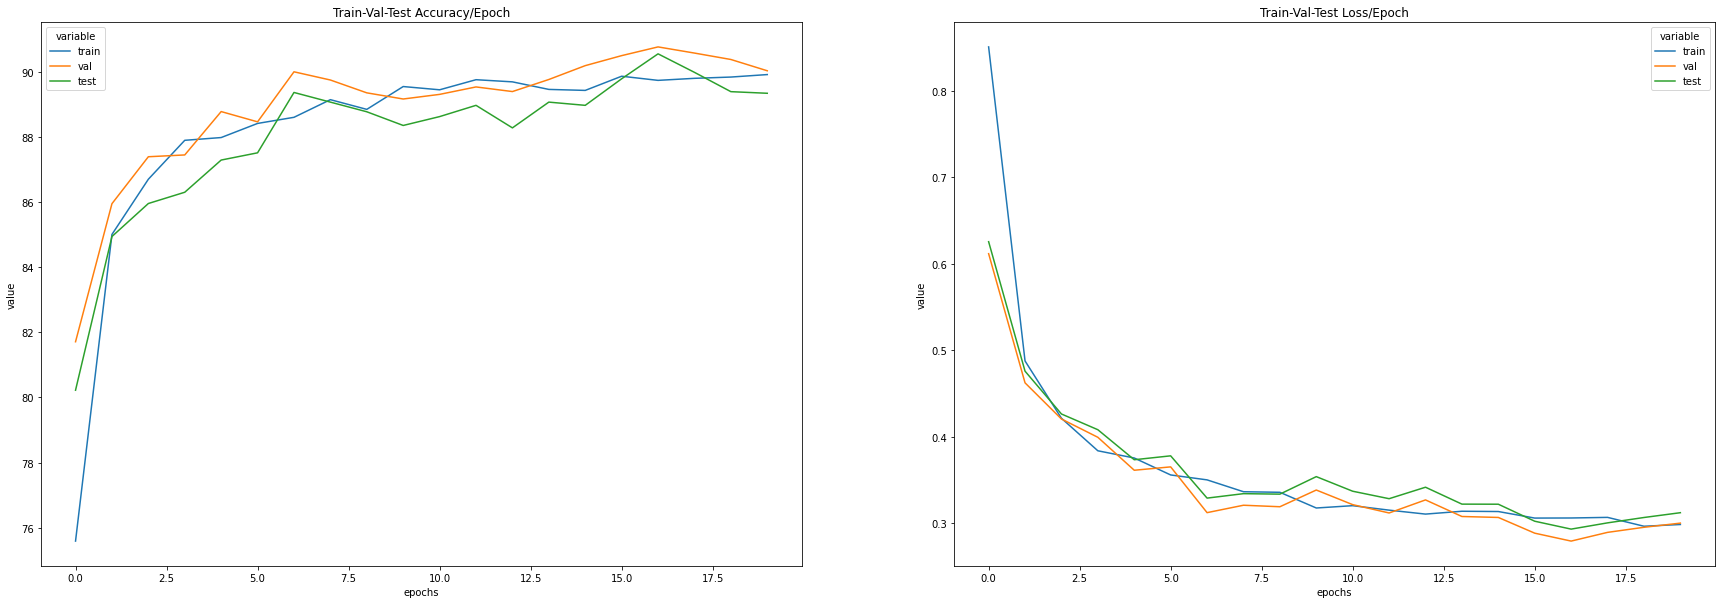

In [ ]:
train_val_test_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_test_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_test_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val-Test Accuracy/Epoch')
sns.lineplot(data=train_val_test_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val-Test Loss/Epoch')

In [ ]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_true_list, y_pred_list, target_names=classes))

                      precision    recall  f1-score   support

          AnnualCrop       0.97      0.86      0.91       452
              Forest       0.95      0.96      0.96       462
HerbaceousVegetation       0.88      0.89      0.88       479
             Highway       0.74      0.89      0.81       378
          Industrial       0.89      0.98      0.93       367
             Pasture       0.86      0.86      0.86       284
       PermanentCrop       0.86      0.86      0.86       390
         Residential       0.94      0.96      0.95       456
               River       0.84      0.73      0.78       375
             SeaLake       0.99      0.91      0.95       407

            accuracy                           0.89      4050
           macro avg       0.89      0.89      0.89      4050
        weighted avg       0.90      0.89      0.89      4050



In [ ]:
cm = confusion_matrix(y_true_list, y_pred_list, labels=range(10))
print(cm)

[[387   0   4  16   0  11  21   0  12   1]
 [  0 444   9   1   0   4   0   2   1   1]
 [  0   5 427  11   3   6  17   7   2   1]
 [  1   1   3 338  11   3   3   7  11   0]
 [  0   0   0   1 358   0   1   7   0   0]
 [  1   5  10   7   0 245   6   1   8   1]
 [  4   1  22  16  10   2 335   0   0   0]
 [  0   2   0   3  10   0   2 439   0   0]
 [  5   3   4  62   9   9   6   3 274   0]
 [  3   4   7   0   0   4   0   0  18 371]]


In [ ]:
for c in range(len(classes)):
  tp = cm[c,c]
  fp = cm[:,c].sum() - tp
  fn = cm[c,:].sum() - tp
  tn = cm.sum() - fp - fn - tp
  #total = tp+fp+fn
  #total_all = cm[:].sum()
  #w = total/total_all
  
  acc = tp/(tp+fp+fn)
  rec =  tp/(tp+fn)
  prec = tp/(tp+fp)
  f1 = 2*tp/(2*tp+fn+fp)

  #w_acc = w*acc
  #w_rec = w*rec
  #w_prec = w*rec
  #w_f1 = w*f1

  print(f'Class: {c} | accuracy for {c}: {acc:2.2f}  | {rec:2.2f} | {prec:2.2f} | {f1:2.2f}')


Class: 0 | accuracy for 0: 0.83  | 0.86 | 0.97 | 0.91
Class: 1 | accuracy for 1: 0.92  | 0.96 | 0.95 | 0.96
Class: 2 | accuracy for 2: 0.79  | 0.89 | 0.88 | 0.88
Class: 3 | accuracy for 3: 0.68  | 0.89 | 0.74 | 0.81
Class: 4 | accuracy for 4: 0.87  | 0.98 | 0.89 | 0.93
Class: 5 | accuracy for 5: 0.76  | 0.86 | 0.86 | 0.86
Class: 6 | accuracy for 6: 0.75  | 0.86 | 0.86 | 0.86
Class: 7 | accuracy for 7: 0.91  | 0.96 | 0.94 | 0.95
Class: 8 | accuracy for 8: 0.64  | 0.73 | 0.84 | 0.78
Class: 9 | accuracy for 9: 0.90  | 0.91 | 0.99 | 0.95


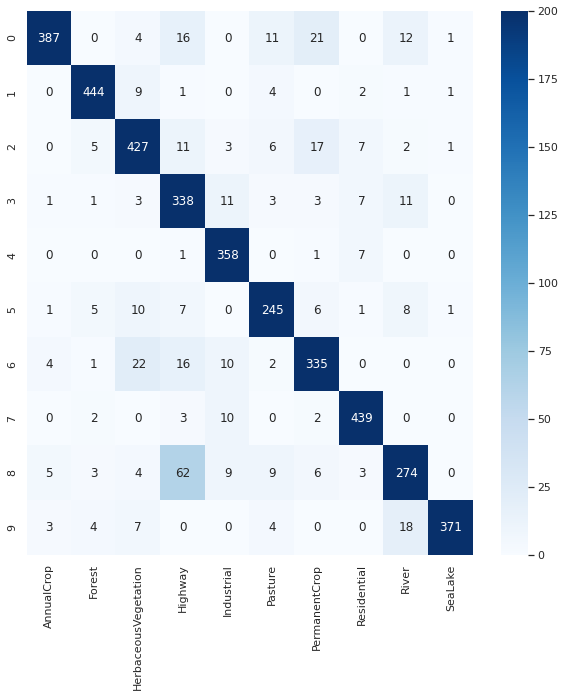

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list))
confusion_matrix_df.columns = classes
plt.figure(figsize = (10,10))
sns.set(font_scale=1)
sns_plot = sns.heatmap(confusion_matrix_df, cmap = 'Blues', annot = True, fmt='g', vmin=0, vmax=200)

CNN

In [ ]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(num_features=64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
        nn.AdaptiveAvgPool2d(output_size=1)
        )
        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=64, out_features=128),
        nn.Dropout(0.5),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=128, out_features=64),
        nn.ReLU(inplace=True),
        nn.Linear(64,10)

        )

    def forward(self, x):
        x = self.conv_features(x)
        x = self.classifier(x)
        return x

model2 = CustomCNN()

In [ ]:
summary(model2.conv_features, (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
              ReLU-2         [-1, 32, 222, 222]               0
         MaxPool2d-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,496
              ReLU-5         [-1, 64, 109, 109]               0
         MaxPool2d-6           [-1, 64, 54, 54]               0
       BatchNorm2d-7           [-1, 64, 54, 54]             128
            Conv2d-8           [-1, 64, 52, 52]          36,928
              ReLU-9           [-1, 64, 52, 52]               0
        MaxPool2d-10           [-1, 64, 26, 26]               0
           Conv2d-11           [-1, 64, 24, 24]          36,928
             ReLU-12           [-1, 64, 24, 24]               0
        MaxPool2d-13           [-1, 64, 12, 12]               0
           Conv2d-14           [-1, 64,

In [ ]:
summary(model2, (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
              ReLU-2         [-1, 32, 222, 222]               0
         MaxPool2d-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,496
              ReLU-5         [-1, 64, 109, 109]               0
         MaxPool2d-6           [-1, 64, 54, 54]               0
       BatchNorm2d-7           [-1, 64, 54, 54]             128
            Conv2d-8           [-1, 64, 52, 52]          36,928
              ReLU-9           [-1, 64, 52, 52]               0
        MaxPool2d-10           [-1, 64, 26, 26]               0
           Conv2d-11           [-1, 64, 24, 24]          36,928
             ReLU-12           [-1, 64, 24, 24]               0
        MaxPool2d-13           [-1, 64, 12, 12]               0
           Conv2d-14           [-1, 64,

In [ ]:
from torch import optim

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr =0.001, momentum=0.9)

In [ ]:
accuracy_stats = {
    'train': [],
    "val": [],
    'test': []
}
loss_stats = {
    'train': [],
    "val": [],
    'test': []
}

In [ ]:
print("Begin training.")
epochs=20
model2.to(device)
for e in tqdm(range(1, epochs+1)):

    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model2.train()
    for image, labels in train_dl:
        image, labels = image.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(image).squeeze()
        train_loss = criterion(outputs, labels)
        train_acc = multi_acc(outputs, labels)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    # VALIDATION
    with torch.no_grad():
        model2.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for image_val, labels_batch in valid_dl:
            image_val, labels_batch = image_val.to(device), labels_batch.to(device)
            val_out = model2(image_val).squeeze()
            val_loss = criterion(val_out, labels_batch)
            val_acc = multi_acc(val_out, labels_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    #TEST
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        test_epoch_loss = 0
        test_epoch_acc = 0
        for img, label in tqdm(test_dl):
            img, label = img.to(device), label.to(device)
            y_test_pred = model2(img)
            test_loss = criterion(y_test_pred, label)
            test_acc = multi_acc(y_test_pred, label)
            test_epoch_loss += test_loss.item()
            test_epoch_acc += test_acc.item()
            
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(label.cpu().numpy())

            

    loss_stats['train'].append(train_epoch_loss/len(train_dl))
    loss_stats['val'].append(val_epoch_loss/len(valid_dl))
    loss_stats['test'].append(test_epoch_loss/len(test_dl))
    accuracy_stats['train'].append(train_epoch_acc/len(train_dl))
    accuracy_stats['val'].append(val_epoch_acc/len(valid_dl))
    accuracy_stats['test'].append(test_epoch_acc/len(test_dl))

    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_dl):.5f} | Val Loss: {val_epoch_loss/len(valid_dl):.5f} | Test Loss: {test_epoch_loss/len(test_dl):.5f} | Train Acc: {train_epoch_acc/len(train_dl):.3f}| Val Acc: {val_epoch_acc/len(valid_dl):.3f} | Test Acc: {test_epoch_acc/len(test_dl):.3f}')



  0%|          | 0/20 [00:00<?, ?it/s]

Begin training.


Streaming output truncated to the last 5000 lines.

 35%|███▍      | 1398/4050 [05:44<09:55,  4.45it/s]


 35%|███▍      | 1399/4050 [05:44<09:43,  4.55it/s]


 35%|███▍      | 1400/4050 [05:44<09:55,  4.45it/s]


 35%|███▍      | 1401/4050 [05:45<11:31,  3.83it/s]


 35%|███▍      | 1403/4050 [05:45<11:54,  3.71it/s]


 35%|███▍      | 1405/4050 [05:46<11:23,  3.87it/s]


 35%|███▍      | 1407/4050 [05:46<10:54,  4.04it/s]


 35%|███▍      | 1409/4050 [05:47<10:27,  4.21it/s]


 35%|███▍      | 1410/4050 [05:47<08:55,  4.93it/s]


 35%|███▍      | 1411/4050 [05:47<10:04,  4.37it/s]


 35%|███▍      | 1412/4050 [05:47<10:41,  4.12it/s]


 35%|███▍      | 1413/4050 [05:47<09:31,  4.62it/s]


 35%|███▍      | 1414/4050 [05:48<09:56,  4.42it/s]


 35%|███▍      | 1415/4050 [05:48<11:18,  3.88it/s]


 35%|███▍      | 1416/4050 [05:48<11:35,  3.79it/s]


 35%|███▍      | 1417/4050 [05:48<10:32,  4.16it/s]


 35%|███▌      | 1418/4050 [05:49<11:30,  3.81it/s]


 35%|███▌      | 1419/4050 [05

Epoch 01: | Train Loss: 2.23272 | Val Loss: 2.06473 | Test Loss: 2.05734 | Train Acc: 18.250| Val Acc: 27.370 | Test Acc: 27.877





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 3/4050 [00:00<02:18, 29.31it/s]


  1%|          | 34/4050 [00:00<01:39, 40.24it/s]


  2%|▏         | 66/4050 [00:00<01:13, 54.47it/s]


  2%|▏         | 98/4050 [00:00<00:54, 72.48it/s]


  3%|▎         | 129/4050 [00:00<00:41, 93.87it/s]


  4%|▍         | 161/4050 [00:00<00:32, 119.12it/s]


  5%|▍         | 194/4050 [00:00<00:26, 146.98it/s]


  6%|▌         | 223/4050 [00:00<00:22, 171.84it/s]


  6%|▋         | 254/4050 [00:00<00:19, 197.30it/s]


  7%|▋         | 285/4050 [00:01<00:17, 220.25it/s]


  8%|▊         | 318/4050 [00:01<00:15, 243.27it/s]


  9%|▊         | 349/4050 [00:01<00:14, 258.62it/s]


  9%|▉         | 380/4050 [00:01<00:13, 272.11it/s]


 10%|█         | 411/4050 [00:01<00:12, 282.13it/s]


 11%|█         | 443/4050 [00:01<00:12, 292.26it/s]


 12%|█▏        | 476/4050 [00:01<00:11, 301.88it/s]


 13%|█▎        | 508/4050 [00:01<00:11, 302.72it/s]


 13%|█▎        | 540/4050 [00:01<00:11, 299.14

Epoch 02: | Train Loss: 1.81379 | Val Loss: 1.53359 | Test Loss: 1.56829 | Train Acc: 30.853| Val Acc: 40.346 | Test Acc: 39.951





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 3/4050 [00:00<02:15, 29.93it/s]


  1%|          | 33/4050 [00:00<01:38, 40.96it/s]


  2%|▏         | 65/4050 [00:00<01:12, 55.29it/s]


  2%|▏         | 97/4050 [00:00<00:53, 73.51it/s]


  3%|▎         | 128/4050 [00:00<00:41, 95.28it/s]


  4%|▍         | 158/4050 [00:00<00:32, 119.65it/s]


  5%|▍         | 187/4050 [00:00<00:26, 144.61it/s]


  5%|▌         | 218/4050 [00:00<00:22, 172.09it/s]


  6%|▌         | 250/4050 [00:00<00:19, 199.22it/s]


  7%|▋         | 282/4050 [00:01<00:16, 223.86it/s]


  8%|▊         | 315/4050 [00:01<00:15, 246.30it/s]


  9%|▊         | 346/4050 [00:01<00:14, 254.17it/s]


  9%|▉         | 376/4050 [00:01<00:13, 265.02it/s]


 10%|█         | 407/4050 [00:01<00:13, 276.42it/s]


 11%|█         | 438/4050 [00:01<00:12, 284.74it/s]


 12%|█▏        | 469/4050 [00:01<00:12, 287.95it/s]


 12%|█▏        | 500/4050 [00:01<00:12, 294.06it/s]


 13%|█▎        | 531/4050 [00:01<00:11, 293.87

Epoch 03: | Train Loss: 1.43926 | Val Loss: 2.18770 | Test Loss: 2.23308 | Train Acc: 41.328| Val Acc: 25.685 | Test Acc: 25.580





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 3/4050 [00:00<02:15, 29.82it/s]


  1%|          | 35/4050 [00:00<01:38, 40.93it/s]


  2%|▏         | 68/4050 [00:00<01:11, 55.35it/s]


  2%|▏         | 100/4050 [00:00<00:53, 73.50it/s]


  3%|▎         | 130/4050 [00:00<00:41, 94.93it/s]


  4%|▍         | 163/4050 [00:00<00:32, 120.28it/s]


  5%|▍         | 194/4050 [00:00<00:26, 147.26it/s]


  6%|▌         | 225/4050 [00:00<00:21, 174.68it/s]


  6%|▋         | 256/4050 [00:00<00:18, 199.82it/s]


  7%|▋         | 288/4050 [00:01<00:16, 224.01it/s]


  8%|▊         | 319/4050 [00:01<00:15, 243.76it/s]


  9%|▊         | 350/4050 [00:01<00:14, 258.75it/s]


  9%|▉         | 382/4050 [00:01<00:13, 274.49it/s]


 10%|█         | 413/4050 [00:01<00:13, 277.05it/s]


 11%|█         | 444/4050 [00:01<00:12, 285.19it/s]


 12%|█▏        | 477/4050 [00:01<00:12, 295.71it/s]


 13%|█▎        | 508/4050 [00:01<00:11, 298.30it/s]


 13%|█▎        | 539/4050 [00:01<00:11, 296.1

Epoch 04: | Train Loss: 1.32005 | Val Loss: 1.46753 | Test Loss: 1.48745 | Train Acc: 46.120| Val Acc: 43.331 | Test Acc: 42.148





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 1/4050 [00:00<06:57,  9.71it/s]


  1%|          | 30/4050 [00:00<04:54, 13.67it/s]


  1%|▏         | 59/4050 [00:00<03:28, 19.13it/s]


  2%|▏         | 88/4050 [00:00<02:29, 26.57it/s]


  3%|▎         | 119/4050 [00:00<01:47, 36.61it/s]


  4%|▎         | 146/4050 [00:00<01:18, 49.43it/s]


  4%|▍         | 170/4050 [00:00<00:59, 64.86it/s]


  5%|▍         | 198/4050 [00:00<00:45, 84.24it/s]


  6%|▌         | 227/4050 [00:00<00:35, 106.83it/s]


  6%|▋         | 257/4050 [00:01<00:28, 131.78it/s]


  7%|▋         | 287/4050 [00:01<00:23, 157.44it/s]


  8%|▊         | 316/4050 [00:01<00:20, 181.81it/s]


  8%|▊         | 344/4050 [00:01<00:18, 200.23it/s]


  9%|▉         | 374/4050 [00:01<00:16, 221.00it/s]


 10%|▉         | 404/4050 [00:01<00:15, 237.76it/s]


 11%|█         | 433/4050 [00:01<00:14, 245.76it/s]


 11%|█▏        | 461/4050 [00:01<00:14, 251.76it/s]


 12%|█▏        | 492/4050 [00:01<00:13, 263.84it/

Epoch 05: | Train Loss: 1.22068 | Val Loss: 1.04992 | Test Loss: 1.05954 | Train Acc: 52.401| Val Acc: 62.031 | Test Acc: 62.568





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 2/4050 [00:00<03:23, 19.93it/s]


  1%|          | 30/4050 [00:00<02:25, 27.61it/s]


  1%|▏         | 57/4050 [00:00<01:45, 37.76it/s]


  2%|▏         | 87/4050 [00:00<01:17, 51.10it/s]


  3%|▎         | 115/4050 [00:00<00:58, 67.62it/s]


  4%|▎         | 143/4050 [00:00<00:44, 87.44it/s]


  4%|▍         | 170/4050 [00:00<00:35, 109.52it/s]


  5%|▍         | 200/4050 [00:00<00:28, 135.03it/s]


  6%|▌         | 228/4050 [00:00<00:23, 159.49it/s]


  6%|▋         | 256/4050 [00:01<00:20, 182.88it/s]


  7%|▋         | 285/4050 [00:01<00:18, 205.00it/s]


  8%|▊         | 313/4050 [00:01<00:17, 217.12it/s]


  8%|▊         | 341/4050 [00:01<00:16, 231.58it/s]


  9%|▉         | 371/4050 [00:01<00:14, 248.02it/s]


 10%|▉         | 399/4050 [00:01<00:14, 255.79it/s]


 11%|█         | 427/4050 [00:01<00:13, 259.87it/s]


 11%|█         | 455/4050 [00:01<00:13, 264.36it/s]


 12%|█▏        | 484/4050 [00:01<00:13, 271.19i

Epoch 06: | Train Loss: 1.09452 | Val Loss: 1.02354 | Test Loss: 1.04072 | Train Acc: 59.453| Val Acc: 61.039 | Test Acc: 61.753





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 1/4050 [00:00<06:45,  9.99it/s]


  1%|          | 28/4050 [00:00<04:46, 14.05it/s]


  1%|▏         | 58/4050 [00:00<03:23, 19.66it/s]


  2%|▏         | 87/4050 [00:00<02:25, 27.28it/s]


  3%|▎         | 117/4050 [00:00<01:44, 37.46it/s]


  4%|▎         | 144/4050 [00:00<01:17, 50.44it/s]


  4%|▍         | 172/4050 [00:00<00:58, 66.81it/s]


  5%|▍         | 200/4050 [00:00<00:44, 86.19it/s]


  6%|▌         | 226/4050 [00:00<00:35, 107.79it/s]


  6%|▋         | 255/4050 [00:01<00:28, 132.47it/s]


  7%|▋         | 283/4050 [00:01<00:23, 157.27it/s]


  8%|▊         | 311/4050 [00:01<00:20, 180.93it/s]


  8%|▊         | 339/4050 [00:01<00:18, 199.28it/s]


  9%|▉         | 368/4050 [00:01<00:16, 219.05it/s]


 10%|▉         | 396/4050 [00:01<00:15, 233.63it/s]


 10%|█         | 424/4050 [00:01<00:15, 236.79it/s]


 11%|█         | 451/4050 [00:01<00:14, 244.13it/s]


 12%|█▏        | 480/4050 [00:01<00:13, 255.12it/

Epoch 07: | Train Loss: 1.00460 | Val Loss: 0.90369 | Test Loss: 0.93229 | Train Acc: 62.785| Val Acc: 66.409 | Test Acc: 65.852





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 3/4050 [00:00<02:17, 29.48it/s]


  1%|          | 30/4050 [00:00<01:39, 40.23it/s]


  1%|▏         | 59/4050 [00:00<01:13, 54.17it/s]


  2%|▏         | 88/4050 [00:00<00:55, 71.53it/s]


  3%|▎         | 118/4050 [00:00<00:42, 92.52it/s]


  4%|▎         | 145/4050 [00:00<00:33, 115.24it/s]


  4%|▍         | 172/4050 [00:00<00:27, 138.86it/s]


  5%|▍         | 199/4050 [00:00<00:23, 162.09it/s]


  6%|▌         | 227/4050 [00:00<00:20, 184.25it/s]


  6%|▋         | 255/4050 [00:01<00:18, 203.72it/s]


  7%|▋         | 282/4050 [00:01<00:17, 219.20it/s]


  8%|▊         | 312/4050 [00:01<00:15, 236.76it/s]


  8%|▊         | 341/4050 [00:01<00:14, 248.83it/s]


  9%|▉         | 370/4050 [00:01<00:14, 258.70it/s]


 10%|▉         | 398/4050 [00:01<00:13, 264.15it/s]


 11%|█         | 428/4050 [00:01<00:13, 270.97it/s]


 11%|█▏        | 457/4050 [00:01<00:13, 270.57it/s]


 12%|█▏        | 486/4050 [00:01<00:12, 275.00

Epoch 08: | Train Loss: 0.94608 | Val Loss: 0.99460 | Test Loss: 1.04492 | Train Acc: 65.406| Val Acc: 64.772 | Test Acc: 64.247





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 1/4050 [00:00<07:01,  9.61it/s]


  1%|          | 30/4050 [00:00<04:57, 13.53it/s]


  1%|▏         | 57/4050 [00:00<03:31, 18.92it/s]


  2%|▏         | 84/4050 [00:00<02:31, 26.24it/s]


  3%|▎         | 110/4050 [00:00<01:49, 35.89it/s]


  3%|▎         | 139/4050 [00:00<01:20, 48.61it/s]


  4%|▍         | 166/4050 [00:00<01:00, 64.43it/s]


  5%|▍         | 193/4050 [00:00<00:46, 83.42it/s]


  5%|▌         | 219/4050 [00:00<00:36, 104.30it/s]


  6%|▌         | 246/4050 [00:01<00:29, 127.02it/s]


  7%|▋         | 273/4050 [00:01<00:25, 149.95it/s]


  7%|▋         | 302/4050 [00:01<00:21, 174.76it/s]


  8%|▊         | 331/4050 [00:01<00:18, 198.00it/s]


  9%|▉         | 359/4050 [00:01<00:17, 214.69it/s]


 10%|▉         | 387/4050 [00:01<00:15, 229.88it/s]


 10%|█         | 416/4050 [00:01<00:14, 243.81it/s]


 11%|█         | 444/4050 [00:01<00:14, 250.09it/s]


 12%|█▏        | 472/4050 [00:01<00:14, 254.53it/

Epoch 09: | Train Loss: 0.88591 | Val Loss: 0.73054 | Test Loss: 0.74163 | Train Acc: 67.584| Val Acc: 72.299 | Test Acc: 72.914





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 1/4050 [00:00<06:48,  9.90it/s]


  1%|          | 29/4050 [00:00<04:48, 13.93it/s]


  1%|▏         | 59/4050 [00:00<03:24, 19.50it/s]


  2%|▏         | 87/4050 [00:00<02:26, 27.05it/s]


  3%|▎         | 114/4050 [00:00<01:46, 37.02it/s]


  4%|▎         | 144/4050 [00:00<01:17, 50.14it/s]


  4%|▍         | 172/4050 [00:00<00:58, 66.47it/s]


  5%|▍         | 200/4050 [00:00<00:44, 86.19it/s]


  6%|▌         | 230/4050 [00:00<00:34, 109.43it/s]


  6%|▋         | 257/4050 [00:01<00:28, 131.96it/s]


  7%|▋         | 287/4050 [00:01<00:23, 158.51it/s]


  8%|▊         | 317/4050 [00:01<00:20, 184.51it/s]


  9%|▊         | 346/4050 [00:01<00:18, 204.80it/s]


  9%|▉         | 377/4050 [00:01<00:16, 226.73it/s]


 10%|█         | 406/4050 [00:01<00:15, 238.94it/s]


 11%|█         | 435/4050 [00:01<00:14, 251.26it/s]


 11%|█▏        | 464/4050 [00:01<00:13, 261.73it/s]


 12%|█▏        | 493/4050 [00:01<00:13, 267.14it/

Epoch 10: | Train Loss: 0.83998 | Val Loss: 0.80574 | Test Loss: 0.82037 | Train Acc: 69.355| Val Acc: 69.165 | Test Acc: 69.259





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 3/4050 [00:00<02:17, 29.49it/s]


  1%|          | 32/4050 [00:00<01:39, 40.37it/s]


  1%|▏         | 60/4050 [00:00<01:13, 54.26it/s]


  2%|▏         | 89/4050 [00:00<00:55, 71.68it/s]


  3%|▎         | 119/4050 [00:00<00:42, 92.68it/s]


  4%|▎         | 150/4050 [00:00<00:33, 117.24it/s]


  4%|▍         | 175/4050 [00:00<00:27, 138.93it/s]


  5%|▍         | 202/4050 [00:00<00:23, 162.19it/s]


  6%|▌         | 230/4050 [00:00<00:20, 184.68it/s]


  6%|▋         | 257/4050 [00:01<00:18, 203.31it/s]


  7%|▋         | 285/4050 [00:01<00:17, 220.41it/s]


  8%|▊         | 315/4050 [00:01<00:15, 239.27it/s]


  9%|▊         | 346/4050 [00:01<00:14, 253.01it/s]


  9%|▉         | 376/4050 [00:01<00:13, 263.61it/s]


 10%|█         | 405/4050 [00:01<00:13, 269.20it/s]


 11%|█         | 435/4050 [00:01<00:13, 275.55it/s]


 11%|█▏        | 464/4050 [00:01<00:13, 270.78it/s]


 12%|█▏        | 492/4050 [00:01<00:13, 273.15

Epoch 11: | Train Loss: 0.79772 | Val Loss: 0.86031 | Test Loss: 0.92686 | Train Acc: 70.893| Val Acc: 66.827 | Test Acc: 65.358





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 1/4050 [00:00<06:56,  9.71it/s]


  1%|          | 32/4050 [00:00<04:53, 13.69it/s]


  2%|▏         | 61/4050 [00:00<03:28, 19.16it/s]


  2%|▏         | 91/4050 [00:00<02:28, 26.63it/s]


  3%|▎         | 121/4050 [00:00<01:47, 36.63it/s]


  4%|▎         | 150/4050 [00:00<01:18, 49.60it/s]


  4%|▍         | 180/4050 [00:00<00:58, 66.05it/s]


  5%|▌         | 210/4050 [00:00<00:44, 86.14it/s]


  6%|▌         | 239/4050 [00:00<00:35, 108.79it/s]


  7%|▋         | 269/4050 [00:01<00:28, 134.31it/s]


  7%|▋         | 298/4050 [00:01<00:23, 159.57it/s]


  8%|▊         | 327/4050 [00:01<00:20, 181.40it/s]


  9%|▉         | 355/4050 [00:01<00:18, 198.81it/s]


  9%|▉         | 383/4050 [00:01<00:16, 217.27it/s]


 10%|█         | 415/4050 [00:01<00:15, 238.47it/s]


 11%|█         | 445/4050 [00:01<00:14, 252.93it/s]


 12%|█▏        | 474/4050 [00:01<00:13, 262.74it/s]


 12%|█▏        | 504/4050 [00:01<00:13, 272.64it/

Epoch 12: | Train Loss: 0.76383 | Val Loss: 0.73655 | Test Loss: 0.75494 | Train Acc: 72.535| Val Acc: 72.031 | Test Acc: 71.926





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 1/4050 [00:00<07:01,  9.60it/s]


  1%|          | 31/4050 [00:00<04:57, 13.52it/s]


  1%|▏         | 55/4050 [00:00<03:32, 18.84it/s]


  2%|▏         | 83/4050 [00:00<02:31, 26.15it/s]


  3%|▎         | 112/4050 [00:00<01:49, 35.96it/s]


  3%|▎         | 141/4050 [00:00<01:20, 48.75it/s]


  4%|▍         | 169/4050 [00:00<01:00, 64.67it/s]


  5%|▍         | 198/4050 [00:00<00:45, 84.11it/s]


  6%|▌         | 225/4050 [00:00<00:36, 105.85it/s]


  6%|▋         | 254/4050 [00:01<00:29, 130.32it/s]


  7%|▋         | 284/4050 [00:01<00:24, 156.19it/s]


  8%|▊         | 312/4050 [00:01<00:20, 179.66it/s]


  8%|▊         | 342/4050 [00:01<00:18, 203.05it/s]


  9%|▉         | 370/4050 [00:01<00:16, 217.16it/s]


 10%|▉         | 398/4050 [00:01<00:15, 231.92it/s]


 11%|█         | 427/4050 [00:01<00:14, 244.41it/s]


 11%|█▏        | 457/4050 [00:01<00:13, 257.21it/s]


 12%|█▏        | 487/4050 [00:01<00:13, 266.05it/

Epoch 13: | Train Loss: 0.73555 | Val Loss: 0.61757 | Test Loss: 0.65178 | Train Acc: 73.411| Val Acc: 76.205 | Test Acc: 75.975





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 3/4050 [00:00<02:16, 29.55it/s]


  1%|          | 34/4050 [00:00<01:39, 40.55it/s]


  2%|▏         | 63/4050 [00:00<01:13, 54.59it/s]


  2%|▏         | 92/4050 [00:00<00:54, 72.08it/s]


  3%|▎         | 121/4050 [00:00<00:42, 92.76it/s]


  4%|▎         | 149/4050 [00:00<00:33, 115.89it/s]


  4%|▍         | 179/4050 [00:00<00:27, 141.58it/s]


  5%|▌         | 210/4050 [00:00<00:22, 169.12it/s]


  6%|▌         | 239/4050 [00:00<00:19, 193.04it/s]


  7%|▋         | 267/4050 [00:01<00:17, 211.62it/s]


  7%|▋         | 297/4050 [00:01<00:16, 231.60it/s]


  8%|▊         | 328/4050 [00:01<00:14, 248.93it/s]


  9%|▉         | 357/4050 [00:01<00:14, 254.18it/s]


 10%|▉         | 387/4050 [00:01<00:13, 265.42it/s]


 10%|█         | 416/4050 [00:01<00:13, 272.31it/s]


 11%|█         | 445/4050 [00:01<00:13, 276.74it/s]


 12%|█▏        | 475/4050 [00:01<00:12, 281.88it/s]


 12%|█▏        | 504/4050 [00:01<00:12, 284.04

Epoch 14: | Train Loss: 0.70841 | Val Loss: 0.72922 | Test Loss: 0.73903 | Train Acc: 74.580| Val Acc: 73.465 | Test Acc: 74.173





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 3/4050 [00:00<02:16, 29.56it/s]


  1%|          | 32/4050 [00:00<01:39, 40.44it/s]


  1%|▏         | 59/4050 [00:00<01:13, 54.24it/s]


  2%|▏         | 90/4050 [00:00<00:55, 71.93it/s]


  3%|▎         | 120/4050 [00:00<00:42, 93.10it/s]


  4%|▎         | 151/4050 [00:00<00:33, 117.67it/s]


  4%|▍         | 180/4050 [00:00<00:27, 142.73it/s]


  5%|▌         | 210/4050 [00:00<00:22, 168.63it/s]


  6%|▌         | 242/4050 [00:00<00:19, 195.66it/s]


  7%|▋         | 271/4050 [00:01<00:17, 215.02it/s]


  7%|▋         | 300/4050 [00:01<00:16, 231.75it/s]


  8%|▊         | 331/4050 [00:01<00:14, 248.26it/s]


  9%|▉         | 363/4050 [00:01<00:13, 264.67it/s]


 10%|▉         | 393/4050 [00:01<00:13, 272.42it/s]


 10%|█         | 423/4050 [00:01<00:12, 279.39it/s]


 11%|█         | 453/4050 [00:01<00:12, 282.19it/s]


 12%|█▏        | 483/4050 [00:01<00:12, 284.10it/s]


 13%|█▎        | 513/4050 [00:01<00:12, 285.03

Epoch 15: | Train Loss: 0.69086 | Val Loss: 0.57649 | Test Loss: 0.61874 | Train Acc: 74.898| Val Acc: 78.661 | Test Acc: 76.840





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 2/4050 [00:00<03:28, 19.43it/s]


  1%|          | 29/4050 [00:00<02:29, 26.91it/s]


  1%|▏         | 60/4050 [00:00<01:47, 37.04it/s]


  2%|▏         | 89/4050 [00:00<01:18, 50.17it/s]


  3%|▎         | 119/4050 [00:00<00:58, 66.86it/s]


  4%|▎         | 149/4050 [00:00<00:44, 86.99it/s]


  4%|▍         | 177/4050 [00:00<00:35, 109.59it/s]


  5%|▌         | 205/4050 [00:00<00:28, 133.60it/s]


  6%|▌         | 235/4050 [00:00<00:23, 159.76it/s]


  7%|▋         | 266/4050 [00:01<00:20, 185.99it/s]


  7%|▋         | 297/4050 [00:01<00:17, 211.01it/s]


  8%|▊         | 326/4050 [00:01<00:16, 226.65it/s]


  9%|▉         | 356/4050 [00:01<00:15, 243.16it/s]


 10%|▉         | 386/4050 [00:01<00:14, 256.28it/s]


 10%|█         | 417/4050 [00:01<00:13, 269.35it/s]


 11%|█         | 447/4050 [00:01<00:13, 275.36it/s]


 12%|█▏        | 477/4050 [00:01<00:12, 281.78it/s]


 13%|█▎        | 507/4050 [00:01<00:12, 286.67i

Epoch 16: | Train Loss: 0.66715 | Val Loss: 0.57555 | Test Loss: 0.61034 | Train Acc: 75.956| Val Acc: 78.535 | Test Acc: 77.852





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 3/4050 [00:00<02:19, 29.02it/s]


  1%|          | 33/4050 [00:00<01:40, 39.78it/s]


  2%|▏         | 65/4050 [00:00<01:13, 53.89it/s]


  2%|▏         | 96/4050 [00:00<00:55, 71.61it/s]


  3%|▎         | 126/4050 [00:00<00:42, 92.77it/s]


  4%|▍         | 158/4050 [00:00<00:33, 117.55it/s]


  5%|▍         | 190/4050 [00:00<00:26, 144.87it/s]


  5%|▌         | 221/4050 [00:00<00:22, 172.02it/s]


  6%|▌         | 252/4050 [00:00<00:19, 198.05it/s]


  7%|▋         | 282/4050 [00:01<00:17, 219.92it/s]


  8%|▊         | 312/4050 [00:01<00:15, 237.41it/s]


  8%|▊         | 342/4050 [00:01<00:14, 252.73it/s]


  9%|▉         | 374/4050 [00:01<00:13, 268.23it/s]


 10%|█         | 405/4050 [00:01<00:13, 278.44it/s]


 11%|█         | 436/4050 [00:01<00:12, 280.31it/s]


 12%|█▏        | 468/4050 [00:01<00:12, 288.97it/s]


 12%|█▏        | 499/4050 [00:01<00:12, 291.93it/s]


 13%|█▎        | 531/4050 [00:01<00:11, 298.59

Epoch 17: | Train Loss: 0.65805 | Val Loss: 0.60326 | Test Loss: 0.65368 | Train Acc: 76.176| Val Acc: 77.276 | Test Acc: 75.309





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 2/4050 [00:00<03:31, 19.10it/s]


  1%|          | 31/4050 [00:00<02:31, 26.54it/s]


  2%|▏         | 62/4050 [00:00<01:49, 36.57it/s]


  2%|▏         | 91/4050 [00:00<01:19, 49.52it/s]


  3%|▎         | 121/4050 [00:00<00:59, 66.05it/s]


  4%|▎         | 151/4050 [00:00<00:45, 86.15it/s]


  4%|▍         | 182/4050 [00:00<00:35, 109.62it/s]


  5%|▌         | 212/4050 [00:00<00:28, 134.90it/s]


  6%|▌         | 241/4050 [00:00<00:23, 160.48it/s]


  7%|▋         | 271/4050 [00:01<00:20, 186.07it/s]


  7%|▋         | 301/4050 [00:01<00:17, 209.99it/s]


  8%|▊         | 333/4050 [00:01<00:15, 233.49it/s]


  9%|▉         | 363/4050 [00:01<00:15, 243.44it/s]


 10%|▉         | 392/4050 [00:01<00:14, 254.39it/s]


 10%|█         | 423/4050 [00:01<00:13, 267.28it/s]


 11%|█         | 453/4050 [00:01<00:13, 275.47it/s]


 12%|█▏        | 483/4050 [00:01<00:12, 281.56it/s]


 13%|█▎        | 514/4050 [00:01<00:12, 287.67i

Epoch 18: | Train Loss: 0.62674 | Val Loss: 0.63745 | Test Loss: 0.66576 | Train Acc: 77.186| Val Acc: 77.354 | Test Acc: 76.568





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 2/4050 [00:00<03:26, 19.62it/s]


  1%|          | 32/4050 [00:00<02:27, 27.26it/s]


  2%|▏         | 64/4050 [00:00<01:46, 37.57it/s]


  2%|▏         | 93/4050 [00:00<01:17, 50.82it/s]


  3%|▎         | 121/4050 [00:00<00:58, 67.33it/s]


  4%|▎         | 150/4050 [00:00<00:44, 87.41it/s]


  4%|▍         | 180/4050 [00:00<00:34, 110.97it/s]


  5%|▌         | 211/4050 [00:00<00:28, 137.09it/s]


  6%|▌         | 242/4050 [00:00<00:23, 163.88it/s]


  7%|▋         | 271/4050 [00:01<00:20, 186.94it/s]


  7%|▋         | 303/4050 [00:01<00:17, 213.42it/s]


  8%|▊         | 334/4050 [00:01<00:15, 235.11it/s]


  9%|▉         | 367/4050 [00:01<00:14, 255.09it/s]


 10%|▉         | 398/4050 [00:01<00:13, 269.22it/s]


 11%|█         | 431/4050 [00:01<00:12, 283.90it/s]


 11%|█▏        | 463/4050 [00:01<00:12, 286.65it/s]


 12%|█▏        | 494/4050 [00:01<00:12, 280.59it/s]


 13%|█▎        | 526/4050 [00:01<00:12, 289.13i

Epoch 19: | Train Loss: 0.62043 | Val Loss: 0.69044 | Test Loss: 0.73081 | Train Acc: 77.418| Val Acc: 74.654 | Test Acc: 73.704





  0%|          | 0/4050 [00:00<?, ?it/s]


  0%|          | 1/4050 [00:00<06:50,  9.85it/s]


  1%|          | 29/4050 [00:00<04:50, 13.87it/s]


  1%|▏         | 56/4050 [00:00<03:26, 19.37it/s]


  2%|▏         | 84/4050 [00:00<02:27, 26.87it/s]


  3%|▎         | 114/4050 [00:00<01:46, 36.95it/s]


  4%|▎         | 145/4050 [00:00<01:17, 50.14it/s]


  4%|▍         | 173/4050 [00:00<00:58, 66.51it/s]


  5%|▍         | 202/4050 [00:00<00:44, 86.17it/s]


  6%|▌         | 230/4050 [00:00<00:35, 108.60it/s]


  6%|▋         | 257/4050 [00:01<00:28, 131.34it/s]


  7%|▋         | 285/4050 [00:01<00:24, 155.95it/s]


  8%|▊         | 314/4050 [00:01<00:20, 180.17it/s]


  9%|▊         | 345/4050 [00:01<00:18, 203.76it/s]


  9%|▉         | 373/4050 [00:01<00:16, 220.19it/s]


 10%|▉         | 403/4050 [00:01<00:15, 237.81it/s]


 11%|█         | 433/4050 [00:01<00:14, 252.34it/s]


 11%|█▏        | 463/4050 [00:01<00:13, 264.35it/s]


 12%|█▏        | 492/4050 [00:01<00:13, 267.84it/

Epoch 20: | Train Loss: 0.60504 | Val Loss: 0.60542 | Test Loss: 0.64986 | Train Acc: 77.986| Val Acc: 78.425 | Test Acc: 76.765


Text(0.5, 1.0, 'Train-Val-Test Loss/Epoch')

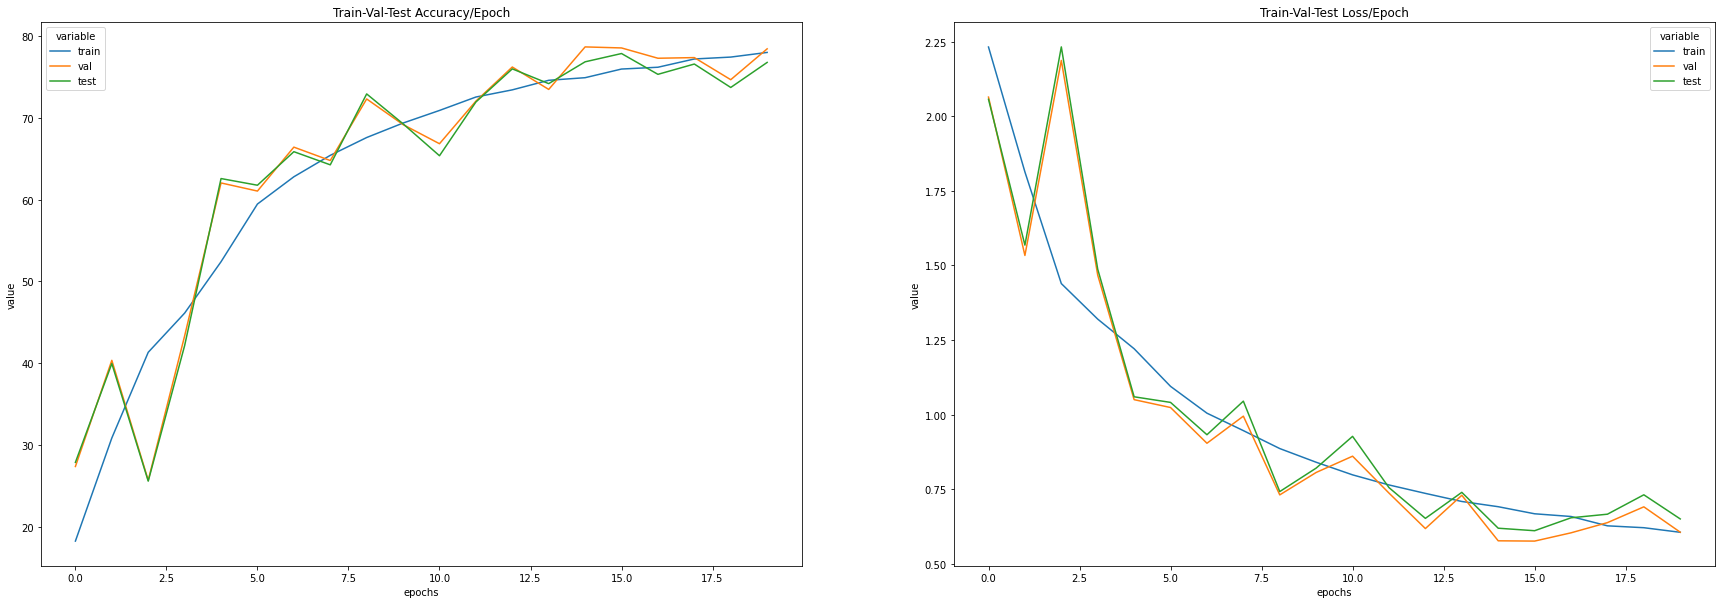

In [ ]:
train_val_test_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_test_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_test_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val-Test Accuracy/Epoch')
sns.lineplot(data=train_val_test_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val-Test Loss/Epoch')

In [ ]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
cm = confusion_matrix(y_true_list, y_pred_list, labels=range(10))
print(cm)

[[391   2   2   5   0   8   8   0  23  13]
 [  0 408  15   1   0   2   0   1   2  33]
 [ 27   2 315  47  27   6  28  19   6   2]
 [  6   0  15 162  62   5   7  10 109   2]
 [  0   0   0   1 364   0   0   2   0   0]
 [  7  24  14  12   0 182   9   0  33   3]
 [ 36   1  51  88  17   0 183   5   9   0]
 [  0   0   2   1  12   0   0 441   0   0]
 [  9   1  10  58  15   4   0   0 274   4]
 [ 13   0   0   0   0   1   0   0   4 389]]


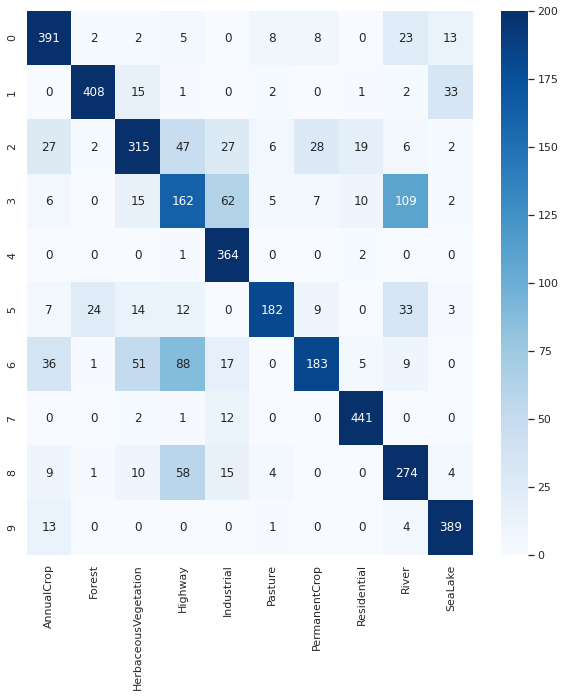

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list))
confusion_matrix_df.columns = classes
plt.figure(figsize = (10,10))
sns.set(font_scale=1)
sns_plot = sns.heatmap(confusion_matrix_df, cmap = 'Blues', annot = True, fmt='g', vmin=0, vmax=200)

CNN Inception Module

In [107]:
from torch.nn.modules.conv import Conv2d
input_channels = 3
class MyNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.incblock = nn.Sequential(
            nn.Conv2d(input_channels,64,1),
            nn.Conv2d(64,96,3,1),
            nn.Conv2d(96,96,3,1)
        )
        self.incblock2 = nn.Sequential(
            nn.Conv2d(input_channels,64,3),
            nn.Conv2d(64,96,3,1)
        )
        self.incblock3 = nn.Sequential(
            nn.Conv2d(input_channels,96,5)
        )
        self.branchpool = nn.Sequential(
            nn.AvgPool2d(1,1),
            nn.Conv2d(3,96,5)
        )
        self.conv_features = nn.Sequential(
            nn.MaxPool2d(kernel_size=8, stride=8),
            nn.AdaptiveAvgPool2d(output_size=1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(384, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128,10)
            )

    def forward(self,x):
        
        x1 = self.incblock(x)
        x2 = self.incblock2(x)
        x3 = self.incblock3(x)
        x4 = self.branchpool(x)
        
        
        #print(x1.shape)
        #print(x2.shape)
        #print(x3.shape)
        #print(x4.shape)

        
        x = torch.cat((x1, x2, x3,x4), 1)
        x = self.conv_features(x)
        x = self.classifier(x)
        return x

model3 = MyNet2()

In [98]:
summary(model3,(3,224,224), device = 'cpu')

torch.Size([2, 96, 220, 220])
torch.Size([2, 96, 220, 220])
torch.Size([2, 96, 220, 220])
torch.Size([2, 96, 220, 220])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             256
            Conv2d-2         [-1, 96, 222, 222]          55,392
            Conv2d-3         [-1, 96, 220, 220]          83,040
            Conv2d-4         [-1, 64, 222, 222]           1,792
            Conv2d-5         [-1, 96, 220, 220]          55,392
            Conv2d-6         [-1, 96, 220, 220]           7,296
         AvgPool2d-7          [-1, 3, 224, 224]               0
            Conv2d-8         [-1, 96, 220, 220]           7,296
         MaxPool2d-9          [-1, 384, 27, 27]               0
AdaptiveAvgPool2d-10            [-1, 384, 1, 1]               0
          Flatten-11                  [-1, 384]               0
           Linear-12                  [-1, 128]

In [108]:
from torch import optim

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr =0.001, momentum=0.9)

In [109]:
accuracy_stats = {
    'train': [],
    "val": [],
    'test': []
}
loss_stats = {
    'train': [],
    "val": [],
    'test': []
}

In [ ]:
print("Begin training.")
epochs=20
model3.to(device)
for e in tqdm(range(1, epochs+1)):

    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model3.train()
    for image, labels in train_dl:
        image, labels = image.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model3(image).squeeze()
        train_loss = criterion(outputs, labels)
        train_acc = multi_acc(outputs, labels)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()

    # VALIDATION
    with torch.no_grad():
        model3.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for image_val, labels_batch in valid_dl:
            image_val, labels_batch = image_val.to(device), labels_batch.to(device)
            val_out = model3(image_val).squeeze()
            val_loss = criterion(val_out, labels_batch)
            val_acc = multi_acc(val_out, labels_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    #TEST
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        test_epoch_loss = 0
        test_epoch_acc = 0
        for img, label in tqdm(test_dl):
            img, label = img.to(device), label.to(device)
            y_test_pred = model3(img)
            test_loss = criterion(y_test_pred, label)
            test_acc = multi_acc(y_test_pred, label)
            test_epoch_loss += test_loss.item()
            test_epoch_acc += test_acc.item()
            
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(label.cpu().numpy())

            

    loss_stats['train'].append(train_epoch_loss/len(train_dl))
    loss_stats['val'].append(val_epoch_loss/len(valid_dl))
    loss_stats['test'].append(test_epoch_loss/len(test_dl))
    accuracy_stats['train'].append(train_epoch_acc/len(train_dl))
    accuracy_stats['val'].append(val_epoch_acc/len(valid_dl))
    accuracy_stats['test'].append(test_epoch_acc/len(test_dl))

    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_dl):.5f} | Val Loss: {val_epoch_loss/len(valid_dl):.5f} | Test Loss: {test_epoch_loss/len(test_dl):.5f} | Train Acc: {train_epoch_acc/len(train_dl):.3f}| Val Acc: {val_epoch_acc/len(valid_dl):.3f} | Test Acc: {test_epoch_acc/len(test_dl):.3f}')




  0%|          | 0/20 [00:00<?, ?it/s]

Begin training.


Streaming output truncated to the last 5000 lines.



 50%|█████     | 2027/4050 [08:09<08:03,  4.18it/s]



 50%|█████     | 2028/4050 [08:09<07:50,  4.30it/s]



 50%|█████     | 2029/4050 [08:09<07:54,  4.26it/s]



 50%|█████     | 2030/4050 [08:10<08:51,  3.80it/s]



 50%|█████     | 2031/4050 [08:10<08:38,  3.90it/s]



 50%|█████     | 2032/4050 [08:10<08:20,  4.03it/s]



 50%|█████     | 2033/4050 [08:10<09:12,  3.65it/s]



 50%|█████     | 2034/4050 [08:11<07:27,  4.50it/s]



 50%|█████     | 2035/4050 [08:11<08:43,  3.85it/s]



 50%|█████     | 2036/4050 [08:11<07:13,  4.65it/s]



 50%|█████     | 2037/4050 [08:11<08:03,  4.16it/s]



 50%|█████     | 2038/4050 [08:12<08:30,  3.94it/s]



 50%|█████     | 2039/4050 [08:12<08:50,  3.79it/s]



 50%|█████     | 2040/4050 [08:12<07:35,  4.41it/s]



 50%|█████     | 2041/4050 [08:12<09:32,  3.51it/s]



 50%|█████     | 2042/4050 [08:13<08:27,  3.96it/s]



 50%|█████     | 2043/4050 [08:13<10:17,  3.25it/s]



 50%|█████ 